# Introduction to Ensembling/Stacking in Python

참고 : https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python

# 1st

In [4]:
# library 불러오기
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')  ### 그래프 결과 확인시 오류 무시

# 아래 5가지 모델을 사용할 예정
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                             GradientBoostingClassifier,ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold   ### 원본엔 cross_validation인데 model_selection으로 이름 바뀜

# 1. Feature Explorations, Engineering and Cleaning

구조화되어있는 대부분의 커널과 비슷하게 진행하며, 데이터를 탐색하고 가능한 feature engineering을 확인하고 모든 범주형 변수를 수치화할 것이다.

In [41]:
# train, test dataset 불러오기
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

# PassengerID를 접근하기 쉽게 저장
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [42]:
full_data = [train,test]  ### train, test 각각 engineering 하지 않기 위해

Name 길이 변수 생성

In [43]:
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

승객의 객실 유무 변수 생성

In [44]:
train['Has_Cabin'] = train['Cabin'].apply(lambda x:0 if type(x)==float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x:0 if type(x)==float else 1)

SibSp과 Parch를 조합해 FamilySize 변수 생성

In [45]:
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1  ### 1은 본인 포함

FamilySize에서 IsAlone 변수 생성

In [46]:
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize']==1,'IsAlone'] = 1  ### Familysize 1이면 혼자

Embarked 열에서 Null 모두 삭제

In [47]:
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

Fare 열에서 Null 모두 삭제

In [48]:
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

CategoricalFare 변수 생성

In [49]:
train['CategoricalFare'] = pd.qcut(train['Fare'],4)

for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()  ### null값 개수
    age_null_random_list = np.random.randint(age_avg-age_std, age_avg+age_std, size=age_null_count)
    ### 나이 평균 +- 표준편차 사이의 null을 대체할 랜덤 값 저장한 리스트
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)  ### 대체한 값 float에서 int로 변환

train['CategoricalAge'] = pd.cut(train['Age'],5)  ### 5살 단위로 범주 분할

Name에서 직함 추출해 Title 변수 생성

In [50]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.',name)
    if title_search:
        return title_search.group(1)
    return ''

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    
# 일반적이지 않은 직함을 Rare로 그룹화
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'],'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle','Miss')
    dataset['Title'] = dataset['Title'].replace('Ms','Miss')
    dataset['Title'] = dataset['Title'].replace('Mme','Mrs')

범주형 변수 수치화 (Sex, Title, Embarked) 및 연속형 변수 범주화 후 수치화 (Fare, Age)

In [51]:
for dataset in full_data:
    # Sex 수치화
    dataset['Sex'] = dataset['Sex'].map({'female': 0, 'male': 1})
    
    # Title 수치화
    title_mapping = {'Mr':1,'Miss':2,'Mrs':3,'Master':4,'Rare':5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)  ### 결측값 0으로 처리
    
    # Embarked 수치화
    dataset['Embarked'] = dataset['Embarked'].map({'S':0,'C':1,'Q':2}).astype(int)
    
    # Fare 범주화 및 수치화
    dataset.loc[dataset['Fare']<=7.91,'Fare'] = 0
    dataset.loc[(dataset['Fare']>7.91)&(dataset['Fare']<=14.454),'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Age 범주화 및 수치화
    dataset.loc[dataset['Age']<=16,'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

변수 선택

In [52]:
drop_elements = ['PassengerId','Name','Ticket','Cabin','SibSp']
train = train.drop(drop_elements, axis=1)
train = train.drop(['CategoricalAge','CategoricalFare'],axis=1)
test = test.drop(drop_elements, axis=1)

데이터 전처리를 마쳤으니 머신러닝 모델에 적합한 변수 형태가 되었을 것이다. 우선 전처리된 데이터셋의 상관관계 및 분포도를 살펴보자.

# 2. Visualization

In [53]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


### Pearson Correlation Heatmap

변수간 얼마나 연관되어있는지 확인하기 위해 상관관계 그래프를 그려보자. Seaborn의 패키지를 사용한다.

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

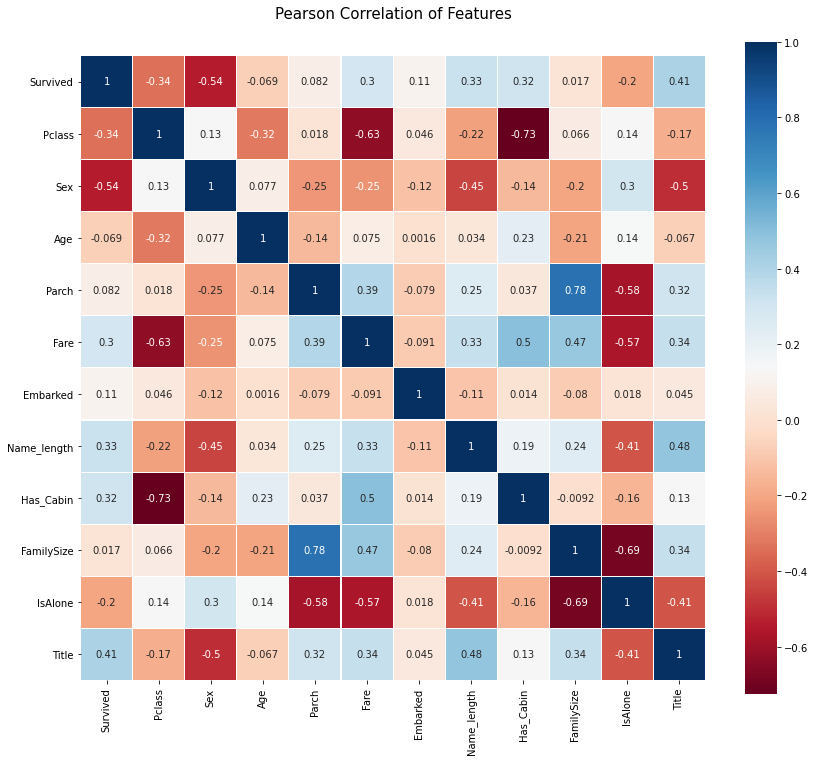

In [54]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0,
           square=True,cmap=colormap,linecolor='white',annot=True)

서로 강한 상관관계가 있는 변수는 많지 않다. train 데이터에 중복되거나 불필요한 데이터가 많지 않다는 것을 알 수 있다. 각 변수가 고유한 정보를 제공하므로 모델에 학습시키기 좋다. Parch와 FamilySize는 상관관계가 높지만 우선 두겠다.

### Pairplots

마지막으로 searborn을 사용한 pariplot을 통해 변수간 분포도를 살펴보자.

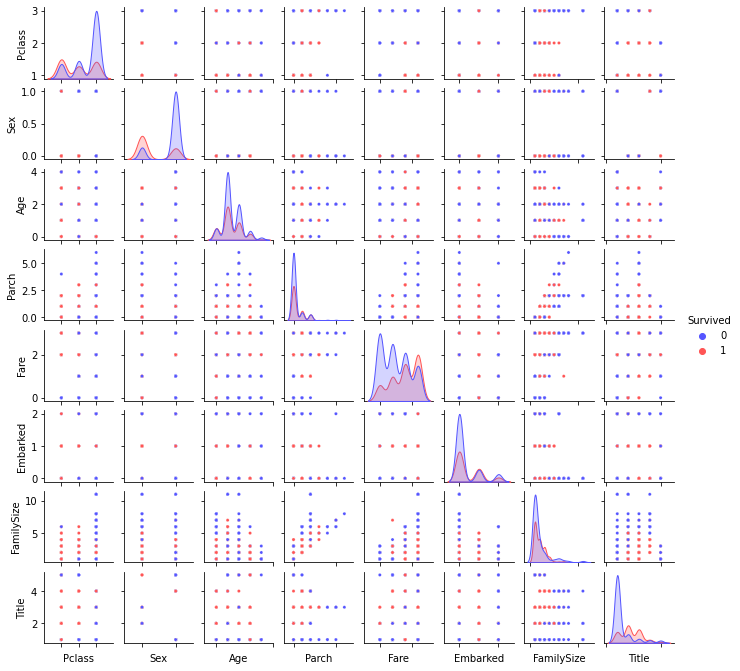

In [56]:
g = sns.pairplot(train[['Survived','Pclass','Sex','Age','Parch','Fare','Embarked',
                       'FamilySize','Title']],hue='Survived',palette='seismic',
                size=1.2,diag_kind='kde',diag_kws=dict(shade=True),
                plot_kws=dict(s=10))
g.set(xticklabels=[])

# 3. Ensembling & Stacking models

여기선 python의 class를 사용한다. 객체지향 프로그래밍(OOP)에서 배우는 클래스는, 객체를 생성하는 코드를 확장하고 클래스에 함수와 메소드를 사용할 수 있다.<br>
skelearn 분류기의 train, predict, fit과 같은 내장 메소드를 분류기 수에 따라 여러번 쓸 필요 없이 중복을 줄이기 위해 SkearnHelper 클래스를 정의할 것이다.

### Helpers via Python Classes

In [69]:
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 
NFOLDS = 5
kf = KFold(n_splits=NFOLDS, random_state=SEED, shuffle=True)
### 원본 오류 -> ntrain 삭제, n_folds는 n_splits으로 대체, shuffle 추가

In [70]:
class SklearnHelper(object):
    def __init__(self,clf,seed=0,params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
        
    def train(self, x_train, y_train):
        self.clf.fit(x_train,y_train)
        
    def predict(self,x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

class 설명
- init : 클래스의 기본 생성자를 호출하는 함수. clf: 원하는 sklearn 분류기, seed: 랜덤시드, params: 분류기의 매개변수
- train, predict, fit, feature_importance : sklearn 분류기에 있는 메소드 호출하는 함수.

### Out-of-Fold Predictions

stcking은 second-level 모델에 학습시킬 기본 분류기를 사용한다.

In [87]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr, y_tr)
        
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i,:] = clf.predict(x_test)
        
    oof_test[:] = oof_test_skf.mean(axis=0)
    
    return oof_train.reshape(-1,1), oof_test.reshape(-1,1)

# 4. Generating our Base First-Level Models

파라미터
- n_jobs : 학습 과정에 사용되는 코어 수. -1은 모든 코어 사용
- n_estimators : 학습 모델의 분류 트리 수. 기본값 10
- max_depth : 트리의 최대 깊이, 혹은 얼마나 확장해야하는지. 너무 높게 설정하면 과적합 위험
- verbose : 학습 과정 중 텍스트를 출력할지 조정. 0은 모든 텍스트 억제, 3은 모든 반복에서 학습 과정 출력

분류기에 넣을 파라미터 저장

In [78]:
# RandomForest
rf_params = {'n_jobs':-1,'n_estimators':500,'warm_start':True,#'max_features':0.2,
            'max_depth':6,'min_samples_leaf':2,'max_features':'sqrt','verbose':0}
# Extra Trees
et_params = {'n_jobs': -1,'n_estimators':500,'max_depth': 8,#'max_features': 0.5,
             'min_samples_leaf': 2,'verbose': 0}
# AdaBoost
ada_params = {'n_estimators': 500,'learning_rate' : 0.75}
# Gradient Boosting parameters
gb_params = {'n_estimators': 500,'max_depth': 5,#'max_features': 0.2,
             'min_samples_leaf': 2,'verbose': 0}
# Support Vector Classifier parameters 
svc_params = {'kernel' : 'linear','C' : 0.025}

위에서 정의한 클래스를 통해 5개의 학습모델 개체를 생성해보자.

In [80]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

원데이터프레임에서 NumPy 어레이를 만들어 분류기에 입력할 train, test 데이터를 만들어보자.

In [81]:
y_train = train['Survived'].ravel()  ### 다차원 dataframe을 1차원으로 펴는 기능
train = train.drop(['Survived'],axis=1)
x_train = train.values  # train data의 array 생성
x_test = test.values

이제 First level 분류기를 정의한 예측 함수를 사용해 5개의 기본 분류기를 학습시켜보자.

In [90]:
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Tree
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

Training is complete


이제 변수 중요도를 확인해보자. 대부분의 분류기는 Sklearn의 .featureimportances 를 입력하기만 하면 변수 중요도를 얻을 수 있다.

In [92]:
rf_feature = rf.feature_importances(x_train,y_train)
et_featrue = et.feature_importances(x_train,y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

[0.10255569 0.21020501 0.03338307 0.01995683 0.04741667 0.02972903
 0.13069521 0.04922994 0.07261554 0.01222674 0.29198627]
[0.12210703 0.38362231 0.02859622 0.01642286 0.05457557 0.02850947
 0.04731393 0.08374394 0.04389221 0.02141861 0.16979783]
[0.028 0.012 0.018 0.064 0.034 0.008 0.696 0.012 0.052 0.006 0.07 ]
[0.08716841 0.01032975 0.04961569 0.01293853 0.04821141 0.02485089
 0.17961332 0.0379103  0.11081113 0.00485167 0.43369889]


In [93]:
rf_features = [0.10255569, 0.21020501, 0.03338307, 0.01995683, 0.04741667, 0.02972903, 0.13069521, 0.04922994, 0.07261554, 0.01222674, 0.29198627]
et_features = [0.12210703, 0.38362231, 0.02859622, 0.01642286, 0.05457557, 0.02850947, 0.04731393, 0.08374394, 0.04389221, 0.02141861, 0.16979783]
ada_features = [0.028, 0.012, 0.018, 0.064, 0.034, 0.008, 0.696, 0.012, 0.052, 0.006, 0.07 ]
gb_features = [0.08716841, 0.01032975, 0.04961569, 0.01293853, 0.04821141, 0.02485089, 0.17961332, 0.0379103, 0.11081113, 0.00485167, 0.43369889]

Plotly 패키지를 통해 쉽게 plot을 그릴 수 있도로고 변수 중요도 리스트를 데이터프레임으로 변경한다.

In [96]:
cols = train.columns.values
feature_dataframe = pd.DataFrame({'features':cols,
                                 'Random Forest feature importances':rf_features,
                                 'Extra Trees feature importances':et_features,
                                 'AdaBoost feature importances':ada_features,
                                 'Gradient Boost feature importances':gb_features})

Plotly의 scatterplot을 통해 변수 중요도를 시각화하여 알아보자.

In [106]:
trace = go.Scatter(y=feature_dataframe['Random Forest feature importances'].values,
                  x=feature_dataframe['features'].values,
                  mode='markers',marker=dict(sizemode='diameter',sizeref=1,size=25,
                                            color=feature_dataframe['Random Forest feature importances'].values,
                                            colorscale='Portland',showscale=True),
                  text=feature_dataframe['features'].values)
data = [trace]
layout = go.Layout(autosize=True,title='Random Forest Feature Importance',hovermode='closest',
                   yaxis=dict(title='Feature Importance',ticklen=5,gridwidth=2),
                  showlegend=False)
fig = go.Figure(data=data,layout=layout)
py.iplot(fig,filename='scatter2010')



trace = go.Scatter(y = feature_dataframe['Extra Trees feature importances'].values,
                   x = feature_dataframe['features'].values, 
                   mode='markers',marker=dict(sizemode = 'diameter',sizeref=1,size=25,
                                              color = feature_dataframe['Extra Trees feature importances'].values,
                                              colorscale='Portland',showscale=True),
                   text = feature_dataframe['features'].values)
data = [trace]
layout= go.Layout(autosize=True,title= 'Extra Trees Feature Importance',hovermode='closest',
                  yaxis=dict(title= 'Feature Importance',ticklen= 5,gridwidth= 2),
                  showlegend= False)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')



trace = go.Scatter(y = feature_dataframe['AdaBoost feature importances'].values,
                   x = feature_dataframe['features'].values, 
                   mode='markers',marker=dict(sizemode = 'diameter',sizeref=1,size=25,
                                              color = feature_dataframe['AdaBoost feature importances'].values,
                                              colorscale='Portland',showscale=True),
                   text = feature_dataframe['features'].values)
data = [trace]
layout= go.Layout(autosize=True,title= 'AdaBoost Feature Importance',hovermode='closest',
                  yaxis=dict(title= 'Feature Importance',ticklen= 5,gridwidth= 2),
                  showlegend= False)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')



trace = go.Scatter(y = feature_dataframe['Gradient Boost feature importances'].values,
                   x = feature_dataframe['features'].values, 
                   mode='markers',marker=dict(sizemode = 'diameter',sizeref=1,size=25,
                                              color = feature_dataframe['Gradient Boost feature importances'].values,
                                              colorscale='Portland',showscale=True),
                   text = feature_dataframe['features'].values)
data = [trace]
layout= go.Layout(autosize=True,title= 'Gradient Boosting Feature Importance',hovermode='closest',
                  yaxis=dict(title= 'Feature Importance',ticklen= 5,gridwidth= 2),
                  showlegend= False)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

변수 중요도의 평균을 데이터프레임에 새 열로 저장한다.

In [108]:
feature_dataframe['mean'] = feature_dataframe.mean(axis=1)  # axis=1 : 행별계산
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.102556,0.122107,0.028,0.087168,0.084958
1,Sex,0.210205,0.383622,0.012,0.010330,0.154039
2,Age,0.033383,0.028596,0.018,0.049616,0.032399


이제 Plotly의 bar plot으로 변수 중요도의 평균을 확인해보자.

In [111]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(x=x,y=y,width=0.5,marker=dict(color=feature_dataframe['mean'].values,
                                            colorscale='Portland',showscale=True,reversescale=False),
              opacity=0.6)]
layout = go.Layout(autosize=True,title='Barplots of Mean Feature Importance',
                  hovermode='closest',yaxis=dict(title='Feature Importance',
                                                ticklen=5,gridwidth=2),showlegend=False)
fig = go.Figure(data=data,layout=layout)
py.iplot(fig,filename='bar-direct-labels')

# 5. Second-Level Predictions from the First-level Output

위에서 first-level 예측을 얻었으므로 다음 분류기의 training data로 사용될 새로운 변수 집합을 만들 수 있다. 새로운 열을 이전 분류기의 first-level 예측으로 하고 다음 분류기를 훈련시킨다.

In [113]:
base_predictions_train = pd.DataFrame({'RandomForest':rf_oof_train.ravel(),
                                      'ExtraTrees':et_oof_train.ravel(),
                                      'AdaBoost':ada_oof_train.ravel(),
                                      'GradientBoost':gb_oof_train.ravel()})
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


second level training set에 대한 상관관계 히트맵을 살펴보자.

In [116]:
data =[go.Heatmap(z=base_predictions_train.astype(float).corr().values,
                 x=base_predictions_train.columns.values,
                 y=base_predictions_train.columns.values,
                 colorscale='Viridis',showscale=True,reversescale=True)]
py.iplot(data,filename='labelled-heatemap')

In [117]:
x_train = np.concatenate((et_oof_train,rf_oof_train,ada_oof_train,gb_oof_train,svc_oof_train),axis=1)
x_test = np.concatenate((et_oof_test,rf_oof_test,ada_oof_test,gb_oof_test,svc_oof_test),axis=1)

이제 first-level 분류기들의의 train과 test 예측을 x_train과 x_test로 결합했으므로 second level 모델을 적합시킬 수 있다.

boosted tree 모델을 위해 유명한 라이브러리 eXtremely를 사용한다.대규모 부스팅 나무 알고리즘을 위해 만들어졌다. 이제 XGB 분류기에 train과 target 데이터를 학습시키고 테스트 데이터를 예측한다.

In [125]:
import xgboost as xgb  ### 맨 위 오타로 다시 
gbm = xgb.XGBClassifier(n_estimators=2000,max_depth=4,min_child_weight=2,gamma=0.9,
                        subsample=0.8,colsample_bytree=0.8,objective='binary:logistic',
                       eval_metric='logloss',  ### 에러나서 추가함
                        nthread=-1,scale_pos_weight=1).fit(x_train,y_train)
predictions = gbm.predict(x_test)

XGBoost 매개변수
- max_depth : 나무의 깊이. 너무 높게 설정하면 과적합 위험
- gamma : 나무의 잎 노드에서 추가적인 분리를 할 때 필요한 최소 손실 감소. 클수록 알고리즘의 보수성이 높아진다.
- n_estimators = 과적합 방지를 위해 각 부스팅 단계에서 사용되는 step 크기 축소

In [126]:
# 제출 파일 생성
StackingSubmission = pd.DataFrame({'PassengerId':PassengerId,'Survived':predictions})
StackingSubmission.to_csv('StackingSubmission.csv',index=False)

# 정리

- 위의 코드는 앙상블의 매우 간단한 방법이다. 아주 높은 수준의 방법으로는 분류기의 조합과 2개 이상의 단계로 분류기를 쌓는다.
- 최적의 매개변수를 찾기 위해 모델을 학습하는 데 교차 검증 전략을 수행할 수 있다.
- 결과의 상관관계가 없을수록 최종 점수가 좋아진다.
- 앙상블 참고하려면 : https://mlwave.com/kaggle-ensembling-guide/